<a href="https://colab.research.google.com/github/huerd/GPA659-E2020/blob/howard%2Fprojectx/_project/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### *Resources*


*   Kernel Visualizations : https://github.com/raghakot/keras-vis
*   Image Files to Numpy Array : https://www.kaggle.com/lgmoneda/from-image-files-to-numpy-arrays
*   MobileNetV2 Dogs/Cats implementation : https://www.kaggle.com/abdallahhassan/dogs-cats-mobilenetv2-transfere-learning









# Per Runtime Setup [Authorization w/ Kaggle database and download]

1.   Set your Kaggle API .JSON file to this runtime
2.   Downloads and extract dogs-vs-cats.zip into two folders



In [3]:
# updates kaggle version
!pip install pillow==7.0.0 
!pip install --upgrade --force-reinstall --no-deps kaggle
from google.colab import files
import zipfile

# select your Kaggle API kaggle.json
uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

# make sure to create a kaggle account, get it verified (phone number and all)
# then go accept terms here : https://www.kaggle.com/c/dogs-vs-cats

# zip should be downloaded to /content/
!kaggle competitions download -c dogs-vs-cats
unzipMaster = zipfile.ZipFile("dogs-vs-cats.zip", 'r')
unzipMaster.extractall()
unzipMaster.close()


# don't expand the folders unless you want colab to crash on you
# file format is 1.jpg, 2.jpg, etc
unzipTest1 = zipfile.ZipFile("test1.zip", 'r')
unzipTest1.extractall()
unzipTest1.close()

# file format is cat.0.jpg, dog.2.jpg, etc
unzipTrain1 = zipfile.ZipFile("train.zip", 'r')
unzipTrain1.extractall()
unzipTrain1.close()

Processing /root/.cache/pip/wheels/57/4e/e8/bb28d035162fb8f17f8ca5d42c3230e284c6aa565b42b72674/kaggle-1.5.6-cp36-none-any.whl
  Found existing installation: kaggle 1.5.6
    Uninstalling kaggle-1.5.6:
      Successfully uninstalled kaggle-1.5.6


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 69 bytes
dogs-vs-cats.zip: Skipping, found more recently modified local copy (use --force to force download)


# Dev Environment Setup

In [4]:

# fix https://github.com/keras-team/keras-preprocessing/issues/116 for datagen
!pip uninstall -y keras-preprocessing
!pip install git+https://github.com/keras-team/keras-preprocessing.git


from __future__ import print_function

# uncomment below to use version 1.x
#%tensorflow_version 1.x
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

from scipy import ndimage
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.layers import Input, Dense, Conv2D, Conv3D, DepthwiseConv2D, SeparableConv2D, Conv3DTranspose
from keras.layers import Flatten, MaxPool2D, AvgPool2D, GlobalAvgPool2D, UpSampling2D, BatchNormalization
from keras.layers import Concatenate, Add, Dropout, ReLU, Lambda, Activation, LeakyReLU, PReLU
import pandas
import numpy
import os, sys
import IPython.display
import PIL.Image
import random

Uninstalling Keras-Preprocessing-1.1.2:
  Successfully uninstalled Keras-Preprocessing-1.1.2
  Cloning https://github.com/keras-team/keras-preprocessing.git to /tmp/pip-req-build-3m25qn0b
  Running command git clone -q https://github.com/keras-team/keras-preprocessing.git /tmp/pip-req-build-3m25qn0b
  Created wheel for Keras-Preprocessing: filename=Keras_Preprocessing-1.1.2-cp36-none-any.whl size=42983 sha256=41cc38b0561b59a99eac3f0c9a3feca3104b0b4f0582a545a1694a8f141994d1
  Stored in directory: /tmp/pip-ephem-wheel-cache-i7465278/wheels/03/a0/39/171f6040d36f36c71168dc69afa81334351b20955dc36ce932
Successfully built Keras-Preprocessing


Using TensorFlow backend.


## Constants

In [5]:
IMAGE_WIDTH = 150
IMAGE_LENGTH = 150
IMAGE_SIZE = [IMAGE_WIDTH, IMAGE_LENGTH]
IMAGE_NUMCHANNELS = 3

TRAININGDATASPLIT_RATIO = 0.9
BATCH_SIZE = 16
EPOCH = 5
SEED = 4

# Data Loading

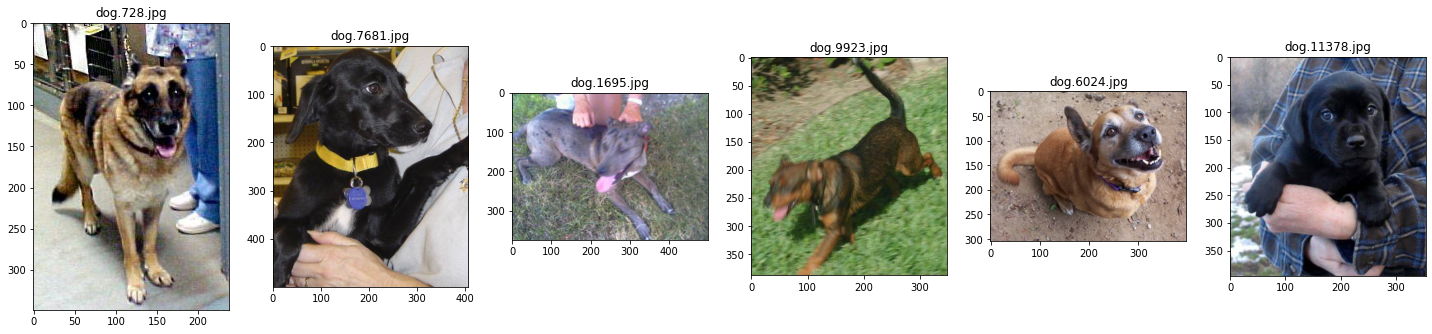

Total Counts from Labeled Data


cat    12500
dog    12500
Name: petType, dtype: int64

In [6]:
labeledData_dir = "train/"
testingData_dir = "test1/"

labeledDataset = os.listdir("train")
testingDataset = os.listdir("test1")

results = []

# loop through our labeledDataset, one file at a time
for eachImage in labeledDataset:
  # recall that our labeledDataset file format is [animal].[num].jpg
  petType = eachImage.split('.')[0]
  if petType == 'cat':
    results.append("cat")
  else:
    results.append("dog")

# df_labeled is where all our labeled data is stored in a DataFrame
df_labeled = pandas.DataFrame({
    'imageName': labeledDataset,
    'petType': results
})

## Visualizations
# create figure size
plt.figure(figsize=(20, 12))
for i in range(0, 6):
    plt.subplot(1, 6, i+1)
    imageName = random.choice(labeledDataset)
    image = load_img(labeledData_dir + imageName)
    plt.title(imageName)
    plt.imshow(image)
plt.tight_layout()
plt.show()

print("Total Counts from Labeled Data")
df_labeled['petType'].value_counts()

## Splitting training dataset into Training and Validation sets

In [7]:
from sklearn.model_selection import train_test_split

# split your labeled dataset into training and validation sets based on a ratio
# if train_size is 0.3, then training is 70% of the dataset
df_training, df_validation = train_test_split(df_labeled, train_size = TRAININGDATASPLIT_RATIO)

# pandas.DataFrame.shape is a tuple
# https://www.programiz.com/python-programming/methods/tuple
total_dfTraining = df_training.shape
total_dfValidation = df_validation.shape


print("Labeled Data Allocation")
fmt = '{:<4} {:<2} {:<15} '
print(fmt.format("Train :", "", str(total_dfTraining[0])))
print(fmt.format("Valid :", "", str(total_dfValidation[0])))

# ref https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main1.ipynb

Labeled Data Allocation
Train :    22500           
Valid :    2500            


### Preprocessing

Check [ImageDataGenerator] Reference : https://keras.io/api/preprocessing/image/
Its purpose : Used for Data Augmentation - takes the original image, applies a bunch of transforms to the original. The class doesn't change.

*   https://www.pyimagesearch.com/2019/07/08/keras-imagedatagenerator-and-data-augmentation/
*   https://colab.research.google.com/github/google/eng-edu/blob/master/ml/pc/exercises/image_classification_part2.ipynb

*   [In-depth on Data Augmentation](https://medium.com/mlait/image-data-augmentation-image-processing-in-tensorflow-part-2-b77237256df0)




Found 22500 validated image filenames belonging to 2 classes.
Visualized Example of Generator.


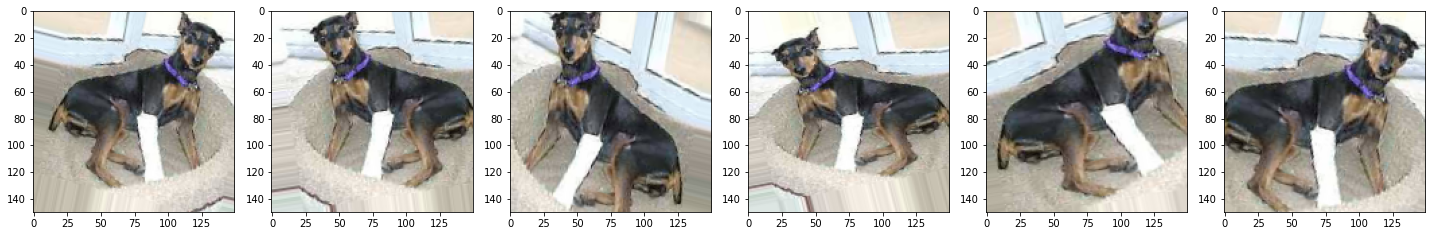

In [8]:
# playing around here I guess
dg_training = ImageDataGenerator(
    rotation_range = 15,
    rescale = 1./255,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip= True,
    fill_mode = 'nearest',
    width_shift_range = 0.1,
    height_shift_range = 0.1
)

# Returns 
# A DataFrameIterator yielding tuples of (x, y) where x is a numpy array 
# containing a batch of images with shape (batch_size, *target_size, channels) 
# and y is a numpy array of corresponding labels.

train_generator = dg_training.flow_from_dataframe(
    df_training, 
    directory = "train/", 
    x_col = 'imageName',
    y_col = 'petType',
    # class_mode = 'binary',
    class_mode = 'categorical',
    target_size = (IMAGE_WIDTH, IMAGE_LENGTH),
    batch_size = BATCH_SIZE,
    subset='training',
    seed = SEED
)

print("Visualized Example of Generator.")
def plotImages(images_arr):
    fig, axes = plt.subplots(1, 6, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip( images_arr, axes):
        ax.imshow(img)
    plt.tight_layout()
    plt.show()

# TODO have it return random images
augmented_images = [train_generator[0][0][0] for i in range(6)]
plotImages(augmented_images)

## Test Data (TODO)

# Model Architecture


*   [MobileNet from scratch](https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main2.ipynb)

In [9]:
# mobile = keras.applications.mobilenet.MobileNet()

def mobilenet(input_shape, n_classes):
  
  # TODO modify this to include pointwise
  # maybe use this ? https://keras.io/api/layers/convolution_layers/separable_convolution2d/
  def mobilenet_block(x, f, s=1):
    x = DepthwiseConv2D(3, strides=s, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    
    x = Conv2D(f, 1, strides=1, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    return x
    
    
  input = Input(input_shape)

  x = Conv2D(32, 3, strides=2, padding='same')(input)
  x = BatchNormalization()(x)
  x = ReLU()(x)

  x = mobilenet_block(x, 64)
  x = mobilenet_block(x, 128, 2)
  x = mobilenet_block(x, 128)

  x = mobilenet_block(x, 256, 2)
  x = mobilenet_block(x, 256)

  x = mobilenet_block(x, 512, 2)
  for _ in range(5):
    x = mobilenet_block(x, 512)

  x = mobilenet_block(x, 1024, 2)
  x = mobilenet_block(x, 1024)
  
  x = GlobalAvgPool2D()(x)
  
  output = Dense(n_classes, activation='softmax')(x)
  
  model = Model(input, output)
  return model

input_shape=(IMAGE_WIDTH, IMAGE_LENGTH, IMAGE_NUMCHANNELS);
n_classes = 4;
model = mobilenet(input_shape,n_classes);
model.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 150, 150, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 75, 75, 32)        896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_1 (ReLU)               (None, 75, 75, 32)        0         
_________________________________________________________________
depthwise_conv2d_1 (Depthwis (None, 75, 75, 32)        320       
_________________________________________________________________
batch_normalization_2 (Batch (None, 75, 75, 32)        128       
_________________________________________________________________
re_lu_2 (ReLU)               (None, 75, 75, 32)        0   

Convert our data to Numpy tables

## Model Summary

## Model Visualization

*   Architecture Visualization : https://github.com/IResearchAI/Tobacco_Leaves_Classification_CNN/blob/master/Tob_main4.ipynb

# Model Accuracy and Loss graphs

# Confusion Matrix